week 4: applied data science capstone part 2 of 2
=================================================

***Using foursquare api to predict the best location for a new Japanese restaurant in Groningen***

**Author:** *Alex de Vries*

### Background
This report will discuss the possibilities of setting up a new Japanese restaurant in the Dutch city of Groningen. This is a student city of around 300.000 people. Because of the university there are students from all over the world. This is not completely represented by the variety of food places in the city. There are two Japanese resaurants that I personaly know of (before starting this analysis). We will find out how many there already are and what the best location would be if someone would want to start a new Japanese restaurant in Groningen. The insights resulting from this analysis could be used for a future business plan.

### Problem
The goal of this analysis is in the end give advise on what the best location for a new Japanese restaurant will be. Because of the limited knowledge of Dutch people regarding Japanese food, any places related to Japanese food will be considered in this analysis. We might even consider Korean food places as any new Japanese place would likely not want to be close to Korean places as it would detract customers. Chinese restaurants are well known and distinquisable for Dutch people so we can leave those out of the analysis.

### Data
This notebook is highly inspirated by the template given in the course. I will keep the idea of clustering the city by area and then plot heatmap to find better area.

I will change some data:
- Country: The Netherlands
- City: Groningen
- Goal: Open a Japanese restaurant/little shop
- So, I will cross data from working days, and localisations.

The following API will be used:
- Foursquare API: to find restaurant/venues
- Google API: reverse geolocalisation

### Library importing


The first step is importing the relevant libraries.
Before importing the libraries an account on foursqueare was created which enables importing geo location data. THis is then analysed using various libraries such as Pandas, Folium, Requests, Math and Shapely.

In [1]:
# This file contains all the ids for foursquare
CLIENT_ID = "UMAV1KOHI434GBVBGDRXLGTXU211YJLCRJ4PJKFZUFDXQV5J"
CLIENT_SECRET = "GZXF3NDHNN2GBQTOYMO2TIWM2QQAW2WIL12CY5FLYGLSMDQT"
VERSION = "20180605"

!pip install folium
# Others imports:
from IPython.display import Image
import pickle
import json
import requests
import folium
import pandas as pd
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from matplotlib import pyplot as plt
!pip install shapely
import shapely.geometry

!pip install pyproj
import pyproj
import math

import warnings
warnings.simplefilter("ignore")
print('importing completed')

%matplotlib inline

     |████████████████████████████████| 1.0MB 1.2MB/s eta 0:00:01
importing completed


### Methodology

In the Methodology section the data is imported, organised and analysed. The longitude and latitude of Groningen is aquired from Google Maps. The radius value is set to 600 based on testing to cover the relevant area. Tese values including the Foursquare secret ID and version are combined in a Foursquare API call. 

In [2]:
groningen_latitude = 53.219383
groningen_longitude = 6.566502
groningen_coords = (groningen_latitude,groningen_longitude)
radius = 600
LIMIT = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    groningen_latitude, 
    groningen_longitude, 
    radius, 
    LIMIT)
print('Coordinates of Groningen: {}'.format(groningen_coords))

Coordinates of Groningen: (53.219383, 6.566502)


In [3]:
results = requests.get(url).json()

The next step after saving the results of the API call is structuring the data in a new dataframe. It will contain two columns with the names 'name' and 'categories'. 
The step after that is to add two new columns to the table for latitude and longitude. The values are find using the following code for each venue and saved in the dataframe.

In [4]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
venues = results['response']['groups'][0]['items']  

grunn_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.crossStreet', 'venue.location.lat', 'venue.location.lng']
grunn_venues =grunn_venues.loc[:, filtered_columns]

# filter the category for each row
grunn_venues['venue.categories'] = grunn_venues.apply(get_category_type, axis=1)

# clean columns
grunn_venues.columns = [col.split(".")[-1] for col in grunn_venues.columns]
grunn_venues.head()


,name,categories,crossStreet,lat,lng
0,Pure Groningen,Frozen Yogurt Shop,Koude Gat,53.217708,6.566397
1,Der Witz,Bar,NaN,53.218259,6.567054
2,Mr. Mofongo,Restaurant,Academieplein,53.219369,6.564100
3,Gustatio,Italian Restaurant,NaN,53.218200,6.568896
4,Grote Markt,Plaza,NaN,53.218754,6.567711


In [6]:
print('{} venues were returned by Foursquare.'.format(grunn_venues.shape[0]))

100 venues were returned by Foursquare.


In [7]:
#Now seperate all venues in different tables so we can plot them with different colors in the folium.map.
restaurant_venues = grunn_venues[grunn_venues['categories'].str.contains('Restaurant')]
cafe_venues = grunn_venues[grunn_venues['categories'].str.contains('Café')]
place_venues = grunn_venues[grunn_venues['categories'].str.contains('Place')]
shop_venues = grunn_venues[grunn_venues['categories'].str.contains('Shop')]
bar_venues = grunn_venues[grunn_venues['categories'].str.contains('Bar')]
cafe_venues.shape[0]

total_venues = pd.DataFrame(columns=['Restaurants', 'Cafes', 'Places', 'Shops' ,'Bars'])
total_venues = total_venues.append({'Restaurants': restaurant_venues.shape[0] , 
                                    'Cafes': cafe_venues.shape[0], 
                                    'Places': place_venues.shape[0], 
                                    'Shops': shop_venues.shape[0], 
                                    'Bars': bar_venues.shape[0]}, 
                                    ignore_index=True)
print('removing non food venues, the remaining venues are shown as follows:')
total_venues

removing non food venues, the remaining venues are shown as follows:


,Restaurants,Cafes,Places,Shops,Bars
0,26,6,7,8,8


### Results

In [12]:
#grunn_venues.name
groningen_map = folium.Map(location=[groningen_latitude, groningen_longitude], zoom_start=15) # generate map centered around the Conrad Hotel

# add the restaurants as red circle markers
for lat, lng, label in zip(restaurant_venues.lat, restaurant_venues.lng, restaurant_venues.name):
    folium.CircleMarker([lat, lng],radius=5, color='red', popup=label, fill = True, fill_color='red', fill_opacity=0.6
    ).add_to(groningen_map)

# add the Cafes as blue circle markers
for lat, lng, label in zip(cafe_venues.lat, cafe_venues.lng, cafe_venues.name):
    folium.CircleMarker([lat, lng], radius=5, color='blue', popup=label, fill = True, fill_color='blue', fill_opacity=0.6
    ).add_to(groningen_map)

# add the places as green circle markers
for lat, lng, label in zip(place_venues.lat, place_venues.lng, place_venues.name):
    folium.CircleMarker([lat, lng], radius=5, color='green', popup=label, fill = True, fill_color='green', fill_opacity=0.6
    ).add_to(groningen_map)
    
# add the restaurants as purple circle markers
for lat, lng, label in zip(shop_venues.lat, shop_venues.lng, shop_venues.name):
    folium.CircleMarker([lat, lng], radius=5, color='purple', popup=label, fill = True, fill_color='purple', fill_opacity=0.6
    ).add_to(groningen_map)    

# add the bars as yellow circle markers
for lat, lng, label in zip(bar_venues.lat, bar_venues.lng, bar_venues.name):
    folium.CircleMarker([lat, lng], radius=5, color='yellow', popup=label, fill = True, fill_color='yellow', fill_opacity=0.6
    ).add_to(groningen_map)

frames = [restaurant_venues, cafe_venues, place_venues, shop_venues, bar_venues]
dining_df = pd.concat(frames)

# display map
groningen_map

In [13]:
#kmeans
grunn_df = dining_df.copy()
grunn_df.drop(['name', 'categories', 'crossStreet'], axis ='columns', inplace = True)

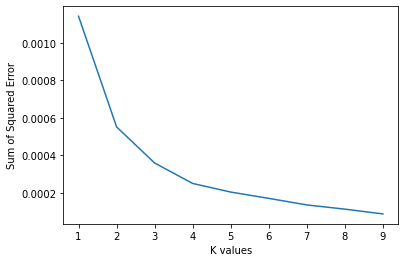

In [24]:
sse = []
k_range = range(1,10)
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(grunn_df)
    sse.append(km.inertia_)
 
plt.xlabel('K values')
plt.ylabel('Sum of Squared Error')
plt.plot(k_range, sse)

In [25]:
km = KMeans(n_clusters=4)
cluster = km.fit_predict(grunn_df)
dining_df['cluster'] = cluster
dining_df.head()

,name,categories,crossStreet,lat,lng,cluster
2,Mr. Mofongo,Restaurant,Academieplein,53.219369,6.564100,3
3,Gustatio,Italian Restaurant,NaN,53.218200,6.568896,0
5,Cho Fah Eatthai,Thai Restaurant,NaN,53.217775,6.568035,0
20,Imono,Sushi Restaurant,NaN,53.217628,6.568279,0
21,Osteria Da Vinci,Italian Restaurant,NaN,53.221979,6.567679,1


In [26]:
df1 = dining_df[dining_df.cluster == 0]
df2 = dining_df[dining_df.cluster == 1]
df3 = dining_df[dining_df.cluster == 2]
df4 = dining_df[dining_df.cluster == 3]


In [27]:
groningen2_map = folium.Map(location=[groningen_latitude, groningen_longitude], zoom_start=15) # generate map centered around the Conrad Hotel

# the for loops make it not work for some reason.
for lat, lng, label in zip(df1.lat, df1.lng, df1.name):
    folium.CircleMarker([lat, lng],radius=5, color='red', popup=label, fill = True, fill_color='red', fill_opacity=0.6
    ).add_to(groningen2_map)
    
for lat, lng, label in zip(df2.lat, df2.lng, df2.name):
    folium.CircleMarker([lat, lng], radius=5, color='blue', popup=label, fill = True, fill_color='blue', fill_opacity=0.6
    ).add_to(groningen2_map)

for lat, lng, label in zip(df3.lat, df3.lng, df3.name):
    folium.CircleMarker([lat, lng], radius=5, color='green', popup=label, fill = True, fill_color='green', fill_opacity=0.6
    ).add_to(groningen2_map)

for lat, lng, label in zip(df4.lat, df4.lng, df4.name):
    folium.CircleMarker([lat, lng], radius=5, color='purple', popup=label, fill = True, fill_color='purple', fill_opacity=0.6
    ).add_to(groningen2_map)
    
groningen2_map

We find looking at the previous two Foursquare plots that firstly the different types of food venues are distributed across the whole city. Secondly we find that food venues can be grouped into 4 sections. These groups do seem to line up with the four sections in which the city itself has been sectioned off in. It is yet too early to make conlusions on the data. The last step is to see if the four groups show a pattern of containing more or less of a particular type of venue.

In [28]:
#the 4 different clusters
df1
df2
df3
df4


venues_per_cluster = pd.DataFrame(columns=['Cluster','Restaurants', 'Cafes', 'Places', 'Shops' ,'Bars'])
venues_per_cluster = venues_per_cluster.append({'Cluster': 'One',
                                    'Restaurants': df1[df1['categories'].str.contains('Restaurant')].shape[0] , 
                                    'Cafes': df1[df1['categories'].str.contains('Café')].shape[0], 
                                    'Places': df1[df1['categories'].str.contains('Place')].shape[0], 
                                    'Shops': df1[df1['categories'].str.contains('Shop')].shape[0], 
                                    'Bars': df1[df1['categories'].str.contains('Bar')].shape[0]}, 
                                    ignore_index=True)

venues_per_cluster = venues_per_cluster.append({'Cluster': 'Two',
                                    'Restaurants': df2[df2['categories'].str.contains('Restaurant')].shape[0] , 
                                    'Cafes': df2[df2['categories'].str.contains('Café')].shape[0], 
                                    'Places': df2[df2['categories'].str.contains('Place')].shape[0], 
                                    'Shops': df2[df2['categories'].str.contains('Shop')].shape[0], 
                                    'Bars': df2[df2['categories'].str.contains('Bar')].shape[0]}, 
                                    ignore_index=True)

venues_per_cluster = venues_per_cluster.append({'Cluster': 'Three',
                                    'Restaurants': df3[df3['categories'].str.contains('Restaurant')].shape[0] , 
                                    'Cafes': df3[df3['categories'].str.contains('Café')].shape[0], 
                                    'Places': df3[df3['categories'].str.contains('Place')].shape[0], 
                                    'Shops': df3[df3['categories'].str.contains('Shop')].shape[0], 
                                    'Bars': df3[df3['categories'].str.contains('Bar')].shape[0]}, 
                                    ignore_index=True)

venues_per_cluster = venues_per_cluster.append({'Cluster': 'Four',
                                    'Restaurants': df4[df4['categories'].str.contains('Restaurant')].shape[0] , 
                                    'Cafes': df4[df4['categories'].str.contains('Café')].shape[0], 
                                    'Places': df4[df4['categories'].str.contains('Place')].shape[0], 
                                    'Shops': df4[df4['categories'].str.contains('Shop')].shape[0], 
                                    'Bars': df4[df4['categories'].str.contains('Bar')].shape[0]}, 
                                    ignore_index=True)

### Discussion
The first thing to note is that the analysis is done purely on Foursquare data. To be more confident in our analysis and conclusions we could crossrefference our findings with a different dataset. 

Based on the final code in the previous chapter we can show the final distribution of various food venues for each section in the city. It can be seen that there is not an equal distribution of each food venue in each section.

In [29]:
print('The following table shows for each cluster the distribution of types of food venues:')
venues_per_cluster

The following table shows for each cluster the distribution of types of food venues:


,Cluster,Restaurants,Cafes,Places,Shops,Bars
0,One,10,1,1,3,3
1,Two,6,2,3,0,1
2,Three,4,1,0,1,0
3,Four,6,2,3,4,4


Percentage of food venues that are restaurants for each cluster:
- Cluster 1: 55% 
- Cluster 2: 50%
- Cluster 3: 66.67%
- Cluster 4: 31.57%

There could be arguments to be made for building a new restaurant in either cluster 3 and cluster 4.
The reason is that cluster 3 is the most popular area for restaurants, namely 66.67% of all food venues are restuarants. This might be a saturated market and cluster 4 is not yet. This could indicate that cluster 4 is the better area for a new restaurant. 

#### Conclusion

The goal of this analysis was to find out the best location for a new restaurant. Initially there was an interest to focus on asian restaurants to decide on the best location of a new Japanese restaurant. It turns out that there are hardly any asian restaurants in the city of Groningen to begin with. Because of this the scope of the analysis was increased to focus on all restaurants and other food related venues.

Currently an argument could be made to build a new restaurant in two different sections of the city. Because the city is easily walkable, visitors could access eaither areas without any difficulties. The east section of the city contains the highest concentration of restaurants which indicates that it is a popular area. Since there are hardly any asian restaurants yet it would stand out and attract visitors. The west section of the city contains the lowest concentration of restaurants. Only 33.57% of all food venues are restaurants. This could indicate a less saturated market.

Advise for future analysis:
It is possible to evaluate foot traffic for the two identified areas to differentiate between them. A second analysis is to review the resaurants ratings or time they have been in business. A last analysis that could be done to decide which area is more ready for a new restaurant is evaluating 